Congratulations! You've decided to treat yourself to a long holiday vacation in Honolulu, Hawaii! To help with your trip planning, you need to do some climate analysis on the area. The following outlines what you need to do.

Trip Dates: May 4 - May 10 (2018)

In [374]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [375]:
import numpy as np
import pandas as pd

In [376]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [377]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [378]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [379]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [380]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [381]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [382]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [383]:
# See what columns/data is in each table - using inspector
inspector = inspect(engine)
measurement_cols = inspector.get_columns('Measurement')
measurement_stat = inspector.get_columns('Station')
#print out columns and data type
for column in measurement_cols:
    print(column['name'], column['type'])
print("-----------------")
for column in measurement_stat:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

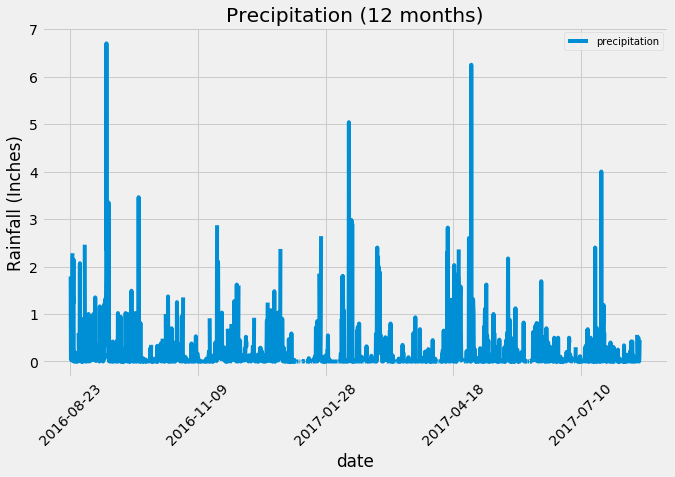

In [400]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#Find last date in database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(10).all()
lastdate
#Calculate new data 1 year ago from last date
newdate = dt.date(2017, 8, 23) - dt.timedelta(days=365)
newdate 

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= newdate).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['date', 'precipitation'])
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date', ascending=True)
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation (12 months)", figsize=(10,6))
plt.legend(loc='upper right', prop={'size': 10})
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='45')
plt.tight_layout
plt.savefig("Images/Precipitation.png",bbox_inches='tight')
plt.show()

In [385]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [386]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"Stations: {stations}")

Stations: 9


In [387]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by((func.count(Measurement.station)).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [388]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"Most Active Station: {station_stats[0][0]}")
print(f"Lowest Temp: {station_stats[0][1]} Highest Temp: {station_stats[0][2]} Average Temp: {round(station_stats[0][3], 2)}")  

Most Active Station: USC00519281
Lowest Temp: 54.0 Highest Temp: 85.0 Average Temp: 71.66


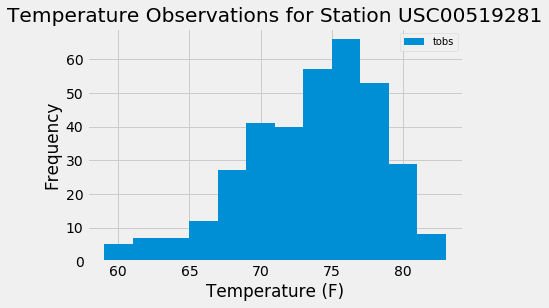

In [401]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temps = session.query(Measurement.tobs).filter(Measurement.date >= newdate).filter(Measurement.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(active_temps, columns=['tobs'])
temp_df

#plot temperature vs. frequency as a histogram
temp_df.plot.hist(bins=12, title="Temperature Observations for Station USC00519281")
plt.legend(loc='upper right', prop={'size': 10})
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
plt.tight_layout
plt.savefig("Images/Temperature.png",bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

In [390]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [391]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-05-04', '2017-05-10')
temps

[(66.0, 75.325, 80.0)]

In [392]:
# create a DF from this query
trip_df = pd.DataFrame(temps, columns=['tmin', 'tavg', 'tmax'])

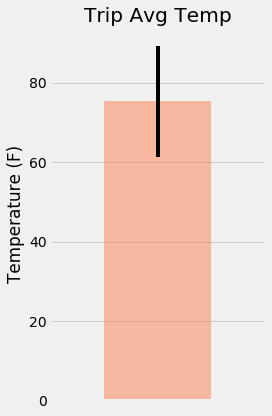

In [393]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6), legend=None)
plt.ylabel("Temperature (F)")
plt.xticks(np.arange(1,1))
plt.tight_layout()
plt.savefig("Images/tripTemps.png")
plt.show()

In [394]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
tot_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-05-04').\
    filter(Measurement.date >= '2017-05-10').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(tot_rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.55), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.06), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.05), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [395]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [396]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip 5/4 - 5/10 2017
start_date = dt.date(2017,5,4)
end_date = dt.date(2017,5,10)

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
    filter(func.strftime ("%Y-%m-%d", Measurement.date) <= end_date).group_by(Measurement.date).all()
date_range

[('2017-05-04'),
 ('2017-05-05'),
 ('2017-05-06'),
 ('2017-05-07'),
 ('2017-05-08'),
 ('2017-05-09'),
 ('2017-05-10')]

In [397]:
# Stip off the year and save a list of %m-%d strings 
#list comprehension to get dates in a duple from query - then strip off year
trip = [d[0] for d in date_range]
trip_dates = [d[5:] for d in trip]

# # Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_dates:
    normals.append(daily_normals(date))
normals

[[(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)],
 [(64.0, 71.78846153846153, 79.0)],
 [(65.0, 72.18867924528301, 80.0)],
 [(67.0, 72.9322033898305, 79.0)],
 [(64.0, 73.3157894736842, 78.0)]]

In [398]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = [np.array(n[0]) for n in normals]
trip_df = pd.DataFrame(trip_normals, columns=['tmin','tavg','tmax'])
trip_df['date'] = trip
trip_df['date'] = pd.to_datetime(trip_df['date'], format='%Y-%m-%d')
trip_df.set_index('date', inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0


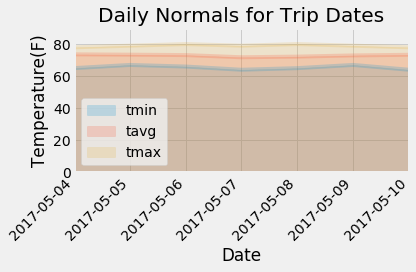

In [399]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, alpha=0.2, x_compat=True, rot = 45, title="Daily Normals for Trip Dates")
plt.ylabel("Temperature(F)")
plt.xlabel("Date")
plt.margins(x=0)
plt.ylim(0,90)
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()